<a href="https://colab.research.google.com/github/lorenafc/MscThesis_EyeTrackingIVR/blob/main/B_fev25_autoencoder_with_rf_overlap_samples_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Fixations in Eye tracking Data in Immersive Virtual Environments using Autoencoder + Random Forest

I am adapting the autoencoder + Random Forest from this original work:

" Autoencoder (MNIST) + Scikit-Learn Random Forest Classifier

A simple, single-hidden-layer, fully-connected autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations). A random forest classifier is then trained for predicting the class labels based on that 32-pixel compressed space.

Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.

Author: Sebastian Raschka GitHub Repository: https://github.com/rasbt/deeplearning-models https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic-with-rf.ipynb "

CPython 3.7.3, IPython 7.9.0, torch 1.3.0

Generative AI is being used to help writting the script and debugging

In [92]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import TensorDataset


In [93]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Read the CSV file
# file_name = '/content/LLA2020_labeled.csv'
file_name = '/content/LLA2020_labeled_feature_eng_veloc_acc.csv'
eye_tracking_data = pd.read_csv(file_name)

Device: cpu


In [94]:
print(eye_tracking_data.head())
print(eye_tracking_data.shape)

    time    L_x     L_y     L_z     C_x     C_y     C_z  viewing_distance  \
0  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940            2.5688   
1  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940            2.5689   
2  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941            2.5691   
3  9.403 -2.969  1.6242 -1.2410 -0.4002  1.6291 -1.2941            2.5694   
4  9.425 -2.969  1.6213 -1.0632 -0.4001  1.6292 -1.2941            2.5793   

   time_diff                coordinates  ...  velocity_deg_s  acceler_deg_s  \
0      0.023  (-2.969, 1.6255, -1.2432)  ...        1.115225      48.488023   
1      0.023   (-2.969, 1.626, -1.2447)  ...        0.775778      33.729487   
2      0.021   (-2.969, 1.6232, -1.243)  ...        1.752291      83.442425   
3      0.022   (-2.969, 1.6242, -1.241)  ...        1.114964      50.680187   
4      0.022  (-2.969, 1.6213, -1.0632)  ...       89.727996    4078.545278   

   observer  GT1  GT2  GT3  GT4  GT5  GT6  GT7  
0         1  

In [95]:
eye_tracking_data_rf = eye_tracking_data.copy()

In [96]:
# Data cleaning
eye_tracking_data = eye_tracking_data.drop(columns=['GT2', 'GT3', 'GT4', 'GT5', 'GT6', 'GT7']) # removing
# eye_tracking_data = eye_tracking_data[['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'GT1','observer']]

In [97]:
print(eye_tracking_data.head(3))

    time    L_x     L_y     L_z     C_x     C_y     C_z  viewing_distance  \
0  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940            2.5688   
1  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940            2.5689   
2  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941            2.5691   

   time_diff                coordinates  coordinates_dist  \
0      0.023  (-2.969, 1.6255, -1.2432)            0.0023   
1      0.023   (-2.969, 1.626, -1.2447)            0.0016   
2      0.021   (-2.969, 1.6232, -1.243)            0.0033   

   cm_to_deg_inside_VE  velocity_deg_s  acceler_deg_s  observer  GT1  
0             0.025650        1.115225      48.488023         1    0  
1             0.017843        0.775778      33.729487         1    0  
2             0.036798        1.752291      83.442425         1    0  


In [98]:
if "time_diff" not in eye_tracking_data.columns:
    eye_tracking_data["time_diff"] = ""
    eye_tracking_data["time_diff"] = eye_tracking_data["time"].diff().fillna(0)
    eye_tracking_data["time_diff"] = pd.to_numeric(eye_tracking_data["time_diff"], errors='coerce')

In [99]:
print(eye_tracking_data.head(3))

    time    L_x     L_y     L_z     C_x     C_y     C_z  viewing_distance  \
0  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940            2.5688   
1  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940            2.5689   
2  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941            2.5691   

   time_diff                coordinates  coordinates_dist  \
0      0.023  (-2.969, 1.6255, -1.2432)            0.0023   
1      0.023   (-2.969, 1.626, -1.2447)            0.0016   
2      0.021   (-2.969, 1.6232, -1.243)            0.0033   

   cm_to_deg_inside_VE  velocity_deg_s  acceler_deg_s  observer  GT1  
0             0.025650        1.115225      48.488023         1    0  
1             0.017843        0.775778      33.729487         1    0  
2             0.036798        1.752291      83.442425         1    0  


### FEATURES

In [100]:
eye_tracking_data = eye_tracking_data.dropna()


In [101]:
eye_tracking_data = eye_tracking_data.drop(columns=['coordinates'])

In [102]:
eye_tracking_data_without_GT1 = eye_tracking_data.drop(columns=['GT1'])

In [103]:
print(eye_tracking_data_without_GT1.head(3))
print("eye_tracking_data_without_GT1 shape:", eye_tracking_data_without_GT1.shape)

    time    L_x     L_y     L_z     C_x     C_y     C_z  viewing_distance  \
0  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940            2.5688   
1  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940            2.5689   
2  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941            2.5691   

   time_diff  coordinates_dist  cm_to_deg_inside_VE  velocity_deg_s  \
0      0.023            0.0023             0.025650        1.115225   
1      0.023            0.0016             0.017843        0.775778   
2      0.021            0.0033             0.036798        1.752291   

   acceler_deg_s  observer  
0      48.488023         1  
1      33.729487         1  
2      83.442425         1  
eye_tracking_data_without_GT1 shape: (106251, 14)


In [104]:
import ast

# Before converting to float32, convert tuple strings to actual tuples
def convert_tuple_string(value):
    try:
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        return value  # Return original value if not a tuple string

for column in eye_tracking_data_without_GT1.select_dtypes(include=['object']).columns:
    eye_tracking_data_without_GT1[column] = eye_tracking_data_without_GT1[column].apply(convert_tuple_string)

# Convert tuple columns to individual numeric columns
def unpack_tuple_column(df, column_name):
    if df[column_name].apply(lambda x: isinstance(x, tuple)).any():
        # Unpack tuple elements into separate columns
        num_elements = len(df[column_name].iloc[0])  # Assuming all tuples have the same length
        new_columns = [f"{column_name}_{i}" for i in range(num_elements)]
        df[new_columns] = pd.DataFrame(df[column_name].tolist(), index=df.index)

        # Drop the original tuple column
        df = df.drop(columns=[column_name])
    return df

# Apply the unpacking function to columns containing tuples
for column in eye_tracking_data_without_GT1.columns:
    eye_tracking_data_without_GT1 = unpack_tuple_column(eye_tracking_data_without_GT1, column)

# # Now convert to float32
# eye_tracking_data_without_GT1 = eye_tracking_data_without_GT1.astype('float32')

In [105]:
# X train and X test without GT1

# Convert columns to float32 for compatibility with PyTorch
eye_tracking_data_without_GT1 = eye_tracking_data_without_GT1.astype('float32')
train_split = 0.75

# Creating data indices for training and test splits: source: LSTM autoencoder time series https://github.com/fabiozappo/LSTM-Autoencoder-Time-Series/blob/main/code/main.py
dataset_size = len(eye_tracking_data_without_GT1)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_without_GT1 = eye_tracking_data_without_GT1.iloc[:split, :]
et_test_without_GT1 = eye_tracking_data_without_GT1.iloc[split:, :]

print("et_train_without_GT1 shape:", et_train_without_GT1.shape)


et_train_without_GT1 shape: (79688, 14)


### LABEL - GT1

In [106]:
eye_tracking_data_GT1 = eye_tracking_data[['GT1']]
print(eye_tracking_data_GT1.head(3))
print("eye_tracking_data_GT1 shape:", eye_tracking_data_GT1.shape)

   GT1
0    0
1    0
2    0
eye_tracking_data_GT1 shape: (106251, 1)


In [107]:
# Convert all columns to float32 for compatibility with PyTorch
eye_tracking_data_GT1 = eye_tracking_data_GT1.astype('float32')

train_split = 0.75
dataset_size = len(eye_tracking_data_GT1)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_GT1 = eye_tracking_data_GT1.iloc[:split, :]
et_test_GT1 = eye_tracking_data_GT1.iloc[split:, :]

In [108]:
print("et_train_GT1 shape:", et_train_GT1.shape)
print("et_test_GT1 shape:", et_test_GT1.shape)

et_train_GT1 shape: (79688, 1)
et_test_GT1 shape: (26563, 1)


# Create overlapping data

In [109]:
# create overlapping data:

def subset_training_data_overlap_by_rows(
    training_data_overlap: pd.DataFrame, rows_interval: int = 460, rows_overlap: int = 135
) -> pd.DataFrame:
    """
    Splits the training_data DataFrame into overlapping subsets for each observer, using row-based intervals.
    Parameters: training_data_overlap (pd.DataFrame): The input DataFrame with an 'observer' column.
                rows_interval (int): The number of rows for each subset.
                rows_overlap (int): The number of overlapping rows for the next subset.
    Returns: pd.DataFrame: A new DataFrame with repeated overlapping rows for each observer, using global subset IDs.
    """
    # Ensure the data is sorted by observer and time
    training_data_overlap = training_data_overlap.sort_values(by=["observer", "time"]).reset_index(drop=True)

    all_subsets = []
    global_subset_id = 1

    # Iterate over each observer
    for observer_id, observer_data in training_data_overlap.groupby("observer"):
        observer_data = observer_data.reset_index(drop=True)

        # Calculate the step for each subset
        subset_step = rows_interval - rows_overlap
        n_rows = len(observer_data)

        # Create subsets using slicing
        for start_idx in range(0, n_rows, subset_step):
            end_idx = start_idx + rows_interval
            current_subset = observer_data.iloc[start_idx:end_idx].copy()

            if not current_subset.empty:
                # Label this subset with a unique global subset ID
                current_subset["subset"] = global_subset_id
                all_subsets.append(current_subset)
                global_subset_id += 1

    # Concatenate all subsets into one DataFrame
    df = pd.concat(all_subsets, ignore_index=True)
    return df

### FEATURES WITH OVERLAPPING - (TEST DATA TO TEST THE MODEL WILL NOT BE OVERLAPPED)

Test data willl not be overlaped, therefore we need to split the data before doing the overlapping

In [110]:
### REMOVE GT1, SPLIT TRAIN/TEST, than overlap: et_train_without_GT1

### OVERLAP TRAINING DATA
# et_train_without_GT1_overlap = subset_training_data_overlap_by_rows(et_train_without_GT1_norm)
et_train_without_GT1_overlap = subset_training_data_overlap_by_rows(et_train_without_GT1)
print(f"et_train_without_GT1_overlap shape is: {et_train_without_GT1_overlap.shape}")

### DONT OVERLAP TEST DATA TO TRAIN AUTOENCODER
# et_test_without_GT1_no_overlap = et_test_without_GT1_norm.copy() #normalized
et_test_without_GT1_no_overlap = et_test_without_GT1.copy()
print(f"et_test_without_GT1_no_overlap shape is: {et_test_without_GT1_no_overlap.shape}")
et_test_without_GT1_no_overlap = et_test_without_GT1_no_overlap.astype('float32')
# et_test_without_GT1_overlap = subset_training_data_overlap_by_rows(et_test_without_GT1)

# Convert all columns to float32 for compatibility with PyTorch
et_train_without_GT1_overlap = et_train_without_GT1_overlap.astype('float32')



et_train_without_GT1_overlap shape is: (108819, 15)
et_test_without_GT1_no_overlap shape is: (26563, 14)


In [111]:
et_train_without_GT1_overlap = et_train_without_GT1_overlap.drop(columns=['subset', 'observer', 'time'])
et_test_without_GT1_no_overlap = et_test_without_GT1_no_overlap.drop(columns=['observer', 'time'])


In [112]:
et_train_without_GT1_overlap

,L_x,L_y,L_z,C_x,C_y,C_z,viewing_distance,time_diff,coordinates_dist,cm_to_deg_inside_VE,velocity_deg_s,acceler_deg_s
0,-2.969,1.6255,-1.2432,-0.4007,1.6290,-1.2940,2.5688,0.023,0.0023,0.025650,1.115224,48.488022
1,-2.969,1.6260,-1.2447,-0.4006,1.6290,-1.2940,2.5689,0.023,0.0016,0.017843,0.775778,33.729488
2,-2.969,1.6232,-1.2430,-0.4004,1.6291,-1.2941,2.5691,0.021,0.0033,0.036798,1.752291,83.442429
3,-2.969,1.6242,-1.2410,-0.4002,1.6291,-1.2941,2.5694,0.022,0.0022,0.024529,1.114964,50.680187
4,-2.969,1.6213,-1.0632,-0.4001,1.6292,-1.2941,2.5793,0.022,0.1778,1.974016,89.727997,4078.545166
...,...,...,...,...,...,...,...,...,...,...,...,...
108814,-2.969,0.9573,1.8967,-0.1379,1.3900,-1.5008,4.4436,0.023,0.0463,0.298493,12.977974,564.259766
108815,-2.969,0.9336,1.9018,-0.1378,1.3900,-1.5007,4.4498,0.022,0.0242,0.155800,7.081802,321.900085
108816,-2.969,0.9196,1.9237,-0.1378,1.3898,-1.5007,4.4680,0.021,0.0260,0.166706,7.938387,378.018463
108817,-2.969,0.9093,1.9320,-0.1377,1.3897,-1.5007,4.4755,0.022,0.0132,0.084494,3.840626,174.573914


In [113]:
et_test_without_GT1_no_overlap

,L_x,L_y,L_z,C_x,C_y,C_z,viewing_distance,time_diff,coordinates_dist,cm_to_deg_inside_VE,velocity_deg_s,acceler_deg_s
79688,-4.9724,0.4638,4.6958,-0.1375,1.3894,-1.5004,7.9137,0.022,3.4322,12.235253,556.147888,25279.449219
79689,-2.9690,0.8912,2.0914,-0.1374,1.3894,-1.5003,4.6007,0.022,3.3135,19.804367,900.198486,40918.113281
79690,-2.9690,0.8812,2.1000,-0.1373,1.3893,-1.5001,4.6084,0.022,0.0132,0.082057,3.729868,169.539444
79691,-2.9690,0.8610,2.0807,-0.1372,1.3892,-1.5000,4.5956,0.022,0.0279,0.173922,7.905523,359.341949
79692,-4.8530,0.4135,4.7060,-0.1371,1.3892,-1.4997,7.8551,0.023,3.2622,11.730680,510.029572,22175.197266
...,...,...,...,...,...,...,...,...,...,...,...,...
106246,-2.9690,1.1224,0.8590,-0.1139,1.5114,-1.4982,3.7228,0.023,0.0051,0.039246,1.706339,74.188629
106247,-2.9690,1.1208,0.8585,-0.1139,1.5114,-1.4982,3.7227,0.023,0.0017,0.013082,0.568795,24.730211
106248,-2.9690,1.1209,0.8566,-0.1138,1.5114,-1.4983,3.7216,0.022,0.0019,0.014626,0.664804,30.218380
106249,-2.9690,1.1262,0.8472,-0.1138,1.5114,-1.4984,3.7152,0.022,0.0108,0.083279,3.785395,172.063416


## OVERLAPPING THE LABEL GT1 - Y TRAIN -
###(Need to overlap the dataset before separatig the features and labels because of the column "observer", used in the function:  subset_training_data_overlap_by_rows)

In [114]:
## SPLIT TRAIN/TEST, than overlap: et_train_GT1
eye_tracking_data_complete = eye_tracking_data.astype('float32')

train_split = 0.75
dataset_size = len(eye_tracking_data_complete)
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))

et_train_complete = eye_tracking_data_complete.iloc[:split, :]
# et_test_GT1 = eye_tracking_data_GT1.iloc[split:, :]

### OVERLAP COMPLETE DATA - NOT POSSIBLE ONLY GT1 BECAUSE THERE IS NO OBSERVER COLUMN

et_train_complete_overlap = subset_training_data_overlap_by_rows(et_train_complete)
print(f"et_train_complete_overlap shape is: {et_train_complete_overlap.shape}\n")
print(et_train_complete_overlap.head(3))

### then REMOVE FEATUES


et_train_complete_overlap shape is: (108819, 16)

    time    L_x     L_y     L_z     C_x     C_y     C_z  viewing_distance  \
0  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940            2.5688   
1  9.360 -2.969  1.6260 -1.2447 -0.4006  1.6290 -1.2940            2.5689   
2  9.381 -2.969  1.6232 -1.2430 -0.4004  1.6291 -1.2941            2.5691   

   time_diff  coordinates_dist  cm_to_deg_inside_VE  velocity_deg_s  \
0      0.023            0.0023             0.025650        1.115224   
1      0.023            0.0016             0.017843        0.775778   
2      0.021            0.0033             0.036798        1.752291   

   acceler_deg_s  observer  GT1  subset  
0      48.488022       1.0  0.0       1  
1      33.729488       1.0  0.0       1  
2      83.442429       1.0  0.0       1  


In [115]:
# Convert all columns to float32 for compatibility with PyTorch

et_train_GT1_overlap = et_train_complete_overlap[['GT1']]

print(f"et_train_GT1_overlap shape is: {et_train_GT1_overlap.shape}\n")

et_train_GT1_overlap shape is: (108819, 1)



## Data Normalization

In [116]:
## DATA NORMALIZATION

# Good practice to keep original dataframes untouched for reusability https://www.datacamp.com/tutorial/normalization-in-machine-learning?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720821&utm_adgroupid=157156374951&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=684592139651&utm_targetid=aud-1940143831083:dsa-2218886984380&utm_loc_interest_ms=&utm_loc_physical_ms=9065007&utm_content=&utm_campaign=230119_1-sea~dsa~tofu_2-b2c_3-row-p1_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&gad_source=1&gclid=Cj0KCQiApNW6BhD5ARIsACmEbkV4CiclaE8Gp-cKYV-93b7n6IT0qCIhGa9hPtTT_SHKo2qodHl_i5kaAn91EALw_wcB

et_train_without_GT1_copy = et_train_without_GT1.copy()
et_test_without_GT1_copy = et_test_without_GT1.copy()


# Fit min-max scaler on training data
norm = MinMaxScaler().fit(et_train_without_GT1_overlap)

# Transform the training data
et_train_without_GT1_overlap_norm = norm.transform(et_train_without_GT1_overlap)
# et_train_without_GT1_overlap_norm = norm.transform(et_train_without_GT1)

# Use the same scaler to transform the testing set
et_test_without_GT1_no_overlap_norm = norm.transform(et_test_without_GT1_no_overlap)
#et_test_without_GT1_overlap_norm = norm.transform(et_test_without_GT1)

In [117]:
# import ast

# # Before converting to float32, convert tuple strings to actual tuples
# def convert_tuple_string(value):
#     try:
#         return ast.literal_eval(value)
#     except (SyntaxError, ValueError):
#         return value  # Return original value if not a tuple string

for column in eye_tracking_data.select_dtypes(include=['object']).columns:
    eye_tracking_data[column] = eye_tracking_data[column].apply(convert_tuple_string)

# # Convert tuple columns to individual numeric columns
# def unpack_tuple_column(df, column_name):
#     if df[column_name].apply(lambda x: isinstance(x, tuple)).any():
#         # Unpack tuple elements into separate columns
#         num_elements = len(df[column_name].iloc[0])  # Assuming all tuples have the same length
#         new_columns = [f"{column_name}_{i}" for i in range(num_elements)]
#         df[new_columns] = pd.DataFrame(df[column_name].tolist(), index=df.index)

#         # Drop the original tuple column
#         df = df.drop(columns=[column_name])
#     return df

# Apply the unpacking function to columns containing tuples
for column in eye_tracking_data.columns:
    eye_tracking_data = unpack_tuple_column(eye_tracking_data, column)

# # Now convert to float32
# eye_tracking_data_without_GT1 = eye_tracking_data_without_GT1.astype('float32')

In [118]:
## y - labels - normalization - NO NEED ITS CLASSIFICATION 0 OR 1

# et_train_GT1_overlap_norm = norm.transform(et_train_GT1_overlap)


In [119]:
et_train_without_GT1_overlap_norm.shape

#et_train_without_GT1_overlap.head(3)

(108819, 12)

In [120]:
print(f"et_train_without_GT1_overlap shape is: {et_train_without_GT1_overlap.shape}")
# print(f"et_test_without_GT1_overlap shape is: {et_test_without_GT1_overlap.shape}")
print(f"et_test_without_GT1_no_overlap shape is: {et_test_without_GT1_no_overlap.shape}")

et_train_without_GT1_overlap shape is: (108819, 12)
et_test_without_GT1_no_overlap shape is: (26563, 12)


In [121]:
print("et_train_without_GT1_overlap_norm shape is:", et_train_without_GT1_overlap_norm.shape)
print("et_test_without_GT1_no_overlap_norm shape is:", et_test_without_GT1_no_overlap_norm.shape)

et_train_without_GT1_overlap_norm shape is: (108819, 12)
et_test_without_GT1_no_overlap_norm shape is: (26563, 12)


In [122]:
et_train_without_GT1_overlap_norm

array([[9.5905173e-01, 4.4425321e-01, 3.3517957e-01, ..., 3.5590748e-04,
        4.8237428e-04, 2.6269737e-04],
       [9.5905173e-01, 4.4429690e-01, 3.3510005e-01, ..., 2.4757817e-04,
        3.8559834e-04, 1.8273892e-04],
       [9.5905173e-01, 4.4405231e-01, 3.3519018e-01, ..., 5.1059015e-04,
        6.6400156e-04, 4.5207265e-04],
       ...,
       [9.5905173e-01, 3.8258803e-01, 5.0303173e-01, ..., 2.3131222e-03,
        2.4276539e-03, 2.0480205e-03],
       [9.5905173e-01, 3.8168827e-01, 5.0347161e-01, ..., 1.1723888e-03,
        1.2593844e-03, 9.4580289e-04],
       [9.5905173e-01, 3.8110298e-01, 5.0409174e-01, ..., 1.1964408e-03,
        1.2332643e-03, 8.8309997e-04]], dtype=float32)

In [123]:
et_test_without_GT1_no_overlap_norm
#et_test_without_GT1_no_overlap.head(3)

array([[8.2645786e-01, 3.4277079e-01, 6.4995861e-01, ..., 1.6976960e-01,
        1.5872183e-01, 1.3695846e-01],
       [9.5905173e-01, 3.8010710e-01, 5.1192015e-01, ..., 2.7479443e-01,
        2.5681046e-01, 2.2168529e-01],
       [9.5905173e-01, 3.7923354e-01, 5.1237595e-01, ..., 1.1385788e-03,
        1.2278074e-03, 9.1852725e-04],
       ...,
       [9.5905173e-01, 4.0017295e-01, 4.4647324e-01, ..., 2.0293806e-04,
        3.5395977e-04, 1.6371651e-04],
       [9.5905173e-01, 4.0063596e-01, 4.4597501e-01, ..., 1.1555291e-03,
        1.2436382e-03, 9.3220157e-04],
       [9.5905173e-01, 4.0081066e-01, 4.4599092e-01, ..., 2.1398700e-04,
        3.5558967e-04, 1.5794506e-04]], dtype=float32)

## FEATURES OVERLAPPED IN THE **ENCODER**

## Using label this time instead of x_copy

In [124]:
# Convert the df to PyTorch tensor
def convert_to_tensor(data, dtype=torch.float32):
    if hasattr(data, 'values'):
      data_to_convert = data.values
    else:
      data_to_convert = data

    return torch.tensor(data_to_convert, dtype=dtype)

# # Convert the df to PyTorch tensor
# def convert_to_tensor(dataframe, dtype=torch.float32):
#     return torch.tensor(dataframe.values, dtype=dtype)


In [125]:
#Using label this time instead of x_copy

X_train_tensor = convert_to_tensor(et_train_without_GT1_overlap_norm) #normalized data in the autoencoder1
y_train_tensor = convert_to_tensor(et_train_GT1_overlap)
X_test_tensor = convert_to_tensor(et_test_without_GT1_no_overlap_norm)
y_test_tensor = convert_to_tensor(et_test_GT1)

#### NO NEED OF LABELS FOR THE AUTOENCODEDRS!!

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}\n")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([108819, 12])
y_train_tensor shape: torch.Size([108819, 1])

X_test_tensor shape: torch.Size([26563, 12])
y_test_tensor shape: torch.Size([26563, 1])


In [126]:
# Create TensorDataset for train and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # the test data is not overlapped

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data: shuffle = False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True) #timeseries data: shuffle = False

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}\n")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([108819, 12])
y_train_tensor shape: torch.Size([108819, 1])

X_test_tensor shape: torch.Size([26563, 12])
y_test_tensor shape: torch.Size([26563, 1])


In [127]:
print(f"train_loader (does not have shape): {train_loader}")
print(f"test_loader shape: {test_loader}")

train_loader (does not have shape): <torch.utils.data.dataloader.DataLoader object at 0x7c6f24dda8d0>
test_loader shape: <torch.utils.data.dataloader.DataLoader object at 0x7c6f24c90e10>


# AUTOENCODER MODEL

In [153]:
# Hyperparameters for the autoencoder model
random_seed = 123
learning_rate = 0.005
num_epochs = 5
weight_decay = 1e-5

# Model architecture settings
input_size = X_train_tensor.shape[1]

num_hidden_2 = 2
num_hidden_1 =  round((num_hidden_2 * input_size)**(1/2)) # First layer in encoder # https://github.com/ari-dasci/S-autoencoder-case-studies/blob/dasci/R/visualization.R
  # Compressed representation layer
# num_hidden_3 = 50   # Uncomment and change value layer 2 if use 3 layers

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        ### ENCODER
        self.encoder_layer1 = nn.Linear(input_size, num_hidden_1)
        self.encoder_layer2 = nn.Linear(num_hidden_1, num_hidden_2)
        # self.encoder_layer3 = nn.Linear(num_hidden_2, num_hidden_3)
        # self.encoder_layer2.weight.detach().normal_(0.0, 0.1)
        # self.encoder_layer2.bias.detach().zero_()


        ### DECODER
        # self.decoder_layer1 = nn.Linear(num_hidden_3, num_hidden_2)
        self.decoder_layer1 = nn.Linear(num_hidden_2, num_hidden_1)
        self.decoder_layer2 = nn.Linear(num_hidden_1, input_size)
        # self.decoder_layer2.weight.detach().normal_(0.0, 0.1)
        # self.decoder_layer2.bias.detach().zero_()

## When using the Sigmoid or TanH functions for hidden layers, it is a good practice to use a “Xavier Normal” or “Xavier Uniform” weight
## initialization (also referred to Glorot initialization, named for Xavier Glorot) and scale input data to the range 0 to 1; -1 to 1 (e.g. the range of the
## activation function) prior to training. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

## How to Choose an Output Activation Function:  If there are two mutually exclusive classes (binary classification), then your output layer will have one node and
## a sigmoid activation function should be used.https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

    def encoder(self, x):
        x = F.relu(self.encoder_layer1(x)) # 3 - relu instead of sigmoid -1, or leaky_relu, 2
        encoded = F.sigmoid(self.encoder_layer2(x))
        return encoded

    def decoder(self, encoded_x):
        x = F.leaky_relu(self.decoder_layer1(encoded_x))
        decoded = torch.sigmoid(self.decoder_layer2(x))  # Sigmoid to get values between 0 and 1
        return decoded

## if using 3 layers:

    # def encoder(self, x):
    #     x = F.sigmoid(self.encoder_layer1(x))
    #     x = F.sigmoid(self.encoder_layer2(x)) ## ADDING A 3DR LAYER
    #     encoded = F.sigmoid(self.encoder_layer3(x)) ## ADDING A 3DR LAYER
    #     return encoded

    # def decoder(self, encoded_x):
    #     x = F.sigmoid(self.decoder_layer1(encoded_x))
    #     x = F.sigmoid(self.decoder_layer2(x)) ## ADDING A 3DR LAYER
    #     decoded = torch.sigmoid(self.decoder_layer3(x))  # Sigmoid to get values between 0 and 1 ## ADDING A 3DR LAYER
    #     return decoded

    def forward(self, x):
        # Flatten input from (batch, sequence_length, features) to (batch, input_size)
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
torch.manual_seed(random_seed)
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=weight_decay) # added regularization (weight decay) L2





#  Training

In [154]:
# Training Loop
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (sequences, _) in enumerate(train_loader):
        sequences = sequences.to(device)

        # Forward pass
        decoded = model(sequences)

        # loss = F.binary_cross_entropy(decoded, sequences.view(sequences.size(0), -1), reduction='mean')
         # reconstruction error
        loss = F.mse_loss(decoded, sequences.view(sequences.size(0), -1)) # changed binary_cross_entropy loss to mse_loss
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Logging
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                  % (epoch + 1, num_epochs, batch_idx, len(train_loader), loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))

Epoch: 001/005 | Batch 000/425 | Loss: 0.1372
Epoch: 001/005 | Batch 050/425 | Loss: 0.0350
Epoch: 001/005 | Batch 100/425 | Loss: 0.0061
Epoch: 001/005 | Batch 150/425 | Loss: 0.0083
Epoch: 001/005 | Batch 200/425 | Loss: 0.0158
Epoch: 001/005 | Batch 250/425 | Loss: 0.0074
Epoch: 001/005 | Batch 300/425 | Loss: 0.0053
Epoch: 001/005 | Batch 350/425 | Loss: 0.0267
Epoch: 001/005 | Batch 400/425 | Loss: 0.0167
Time elapsed: 0.03 min
Epoch: 002/005 | Batch 000/425 | Loss: 0.0194
Epoch: 002/005 | Batch 050/425 | Loss: 0.0140
Epoch: 002/005 | Batch 100/425 | Loss: 0.0023
Epoch: 002/005 | Batch 150/425 | Loss: 0.0057
Epoch: 002/005 | Batch 200/425 | Loss: 0.0107
Epoch: 002/005 | Batch 250/425 | Loss: 0.0068
Epoch: 002/005 | Batch 300/425 | Loss: 0.0045
Epoch: 002/005 | Batch 350/425 | Loss: 0.0255
Epoch: 002/005 | Batch 400/425 | Loss: 0.0158
Time elapsed: 0.06 min
Epoch: 003/005 | Batch 000/425 | Loss: 0.0192
Epoch: 003/005 | Batch 050/425 | Loss: 0.0145
Epoch: 003/005 | Batch 100/425 | L

## Testing Autoencoders' Model Accuracy and visualizing differences after reconstructing:

In [155]:
# Testing autoencoders' model accuracy:

# source: https://saturncloud.io/blog/calculating-the-accuracy-of-pytorch-models-every-epoch/#:~:text=In%20order%20to%20calculate%20the,tensor%20along%20a%20specified%20dimension.



tolerance = 0.05

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        # Move the data to the device (CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # _, predicted = torch.max(outputs, 1)

        # Update the running total of correct predictions and samples
        total_correct += torch.sum(torch.abs(images - outputs) <= tolerance).item() #(images == outputs).sum().item()
        total_samples += images.nelement() #labels.size(0)

    # Calculate the accuracy for this epoch
    accuracy = 100 * total_correct / total_samples
    print(f'Epoch {epoch+1}: Accuracy = {accuracy:.2f}%')

# https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch/63271002#63271002



Epoch 1: Accuracy = 74.94%
Epoch 2: Accuracy = 74.94%
Epoch 3: Accuracy = 74.94%
Epoch 4: Accuracy = 74.94%
Epoch 5: Accuracy = 74.94%


In [156]:
 # Its not really working, because when tolerance = 0, accuracy is 0 what is not
 # true because there are values that are the same in image and outputs

import builtins

tolerance = 0.005 # testing with tolerance  = 0.005

for epoch in range(num_epochs):
    epoch_accuracy = []  # Store accuracy for each row in the epoch

    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate accuracy for each row
        for i in range(images.shape[0]):

            diff = torch.abs((images[i] - outputs[i])/images[i]) # here I made the proportion instead of difference

            # Count values within tolerance
            row_correct = torch.sum(diff <= tolerance).item()
            row_total = images[i].nelement()
            row_accuracy = 100 * row_correct / row_total
            epoch_accuracy.append(row_accuracy)

    average_accuracy = builtins.sum(epoch_accuracy) / len(epoch_accuracy) if epoch_accuracy else 0
    print(f'Epoch {epoch+1}: Average Accuracy = {average_accuracy:.2f}%')

Epoch 1: Average Accuracy = 6.34%
Epoch 2: Average Accuracy = 6.34%
Epoch 3: Average Accuracy = 6.34%
Epoch 4: Average Accuracy = 6.34%
Epoch 5: Average Accuracy = 6.34%


# GridSearch:



In [157]:
# for epoch in range(num_epochs):
#     epoch_accuracy = []

#     for images, labels in test_loader:

#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images)

#         # Calculate accuracy for each row
#         for i in range(images.shape[0]):
#             # Count exact matching values in the row
#             row_correct = torch.sum(images[i] == outputs[i]).item()
#             row_total = images[i].nelement()
#             row_accuracy = 100 * row_correct / row_total
#             epoch_accuracy.append(row_accuracy)

#     # Calculate average accuracy for the epoch
#     average_accuracy = sum(epoch_accuracy) / len(epoch_accuracy) if epoch_accuracy else 0
#     print(f'Epoch {epoch+1}: Average Accuracy = {average_accuracy:.2f}%')

In [158]:
## R2 and MSE
from sklearn.metrics import mean_squared_error, r2_score


In [159]:
mse = mean_squared_error(images.cpu().numpy(), outputs.cpu().detach().numpy())
print(f"MSE: {round(mse, 2)}")

r2 = r2_score(images.cpu().numpy(), outputs.cpu().detach().numpy())
print(f"R2: {round(r2,2)}")

MSE: 0.01
R2: -337.65


In [160]:
print(images)


tensor([[9.5905e-01, 4.1448e-01, 3.2416e-01,  ..., 3.2423e-03, 3.1926e-03,
         2.6156e-03],
        [9.5905e-01, 4.1622e-01, 3.2315e-01,  ..., 3.8314e-03, 3.7428e-03,
         3.0909e-03],
        [9.5905e-01, 4.1433e-01, 3.2369e-01,  ..., 3.3392e-03, 3.1475e-03,
         2.4647e-03],
        ...,
        [9.5905e-01, 4.3900e-01, 3.0710e-01,  ..., 8.5794e-04, 9.6570e-04,
         6.9213e-04],
        [9.5905e-01, 4.3952e-01, 3.0742e-01,  ..., 1.1489e-03, 1.2375e-03,
         9.2688e-04],
        [9.5905e-01, 4.4645e-01, 3.0028e-01,  ..., 2.1509e-02, 2.0252e-02,
         1.7352e-02]])


In [161]:
print(outputs)

tensor([[0.9667, 0.4105, 0.3549,  ..., 0.0229, 0.0228, 0.0165],
        [0.9667, 0.4105, 0.3548,  ..., 0.0229, 0.0228, 0.0165],
        [0.9667, 0.4105, 0.3548,  ..., 0.0229, 0.0228, 0.0165],
        ...,
        [0.9672, 0.4106, 0.3536,  ..., 0.0226, 0.0225, 0.0162],
        [0.9672, 0.4106, 0.3536,  ..., 0.0226, 0.0225, 0.0162],
        [0.9671, 0.4106, 0.3539,  ..., 0.0226, 0.0226, 0.0163]],
       grad_fn=<SigmoidBackward0>)


In [162]:
num_samples_to_visualize = 10
original_data = images[:num_samples_to_visualize].cpu().numpy()
reconstructed_data = outputs[:num_samples_to_visualize].cpu().detach().numpy()

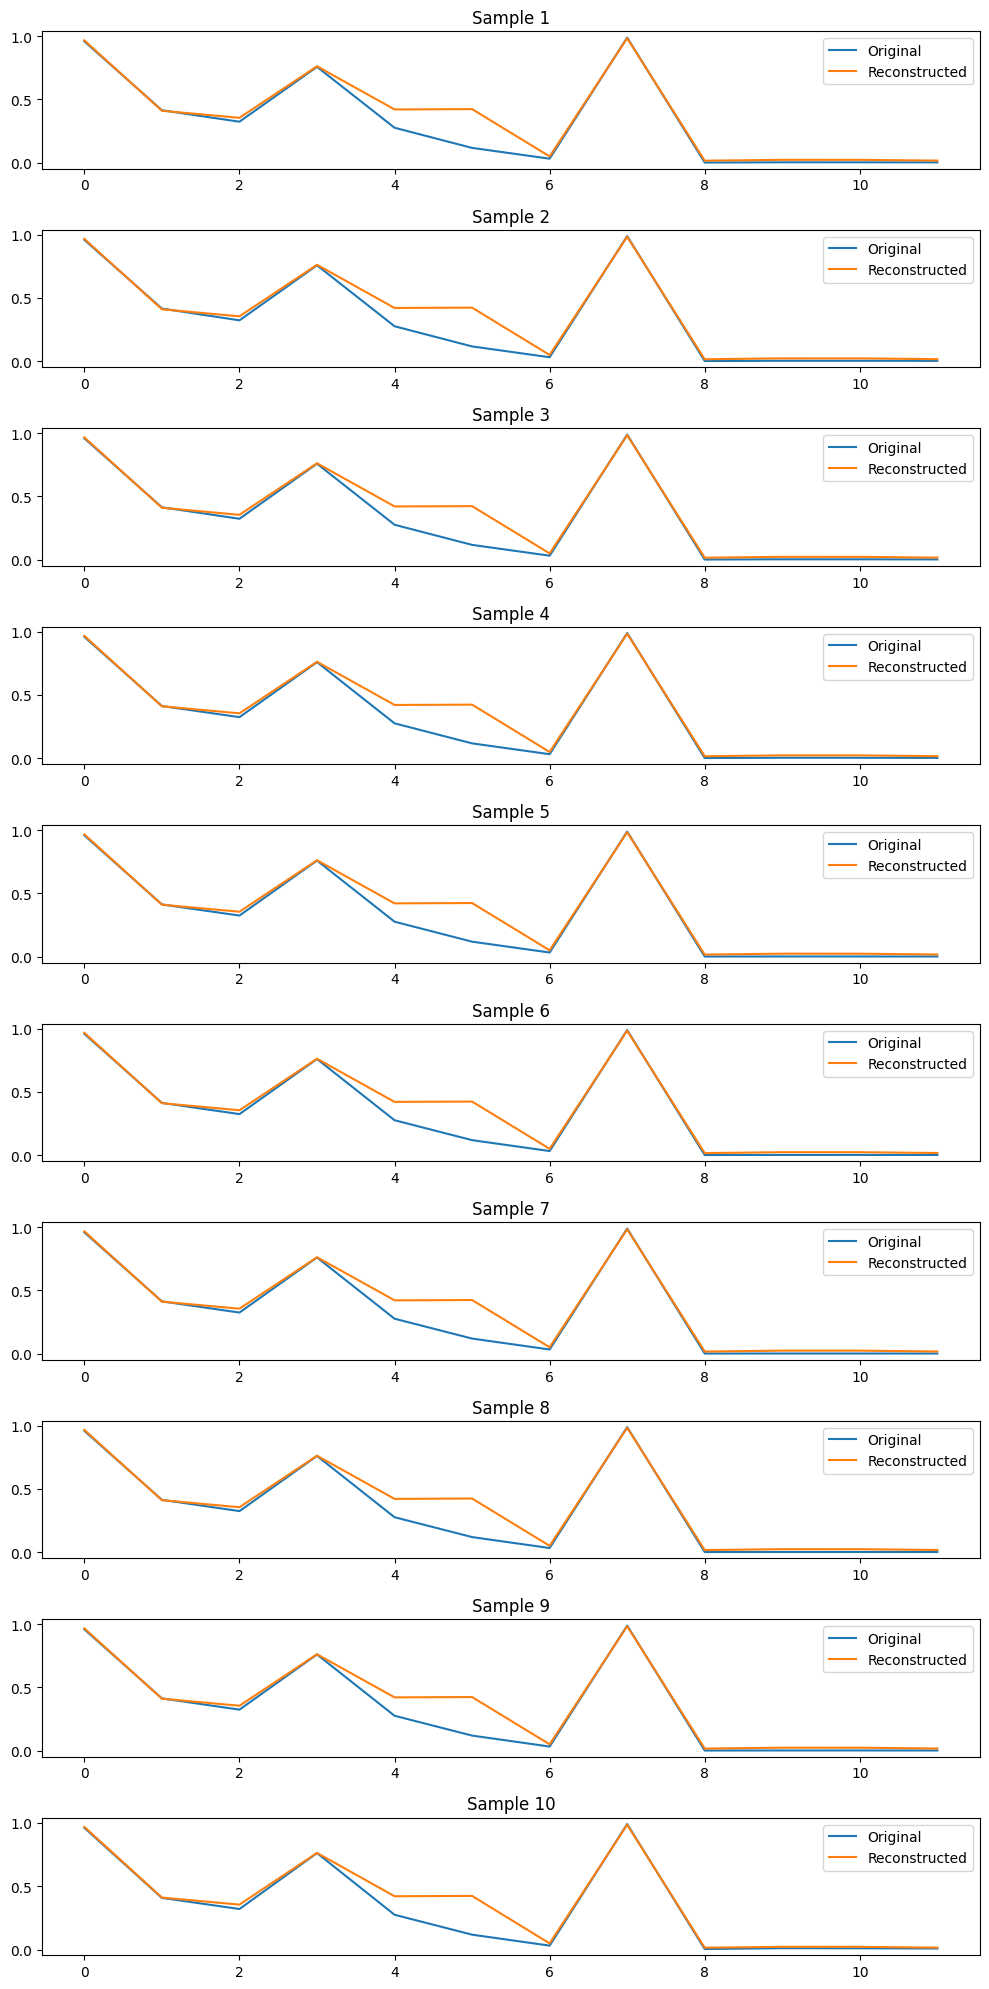

In [163]:
import matplotlib.pyplot as plt

# Creating subplots
fig, axes = plt.subplots(num_samples_to_visualize, 1, figsize=(10, 2 * num_samples_to_visualize))

# Looping through each sample
for i in range(num_samples_to_visualize):
    axes[i].plot(original_data[i], label='Original')
    axes[i].plot(reconstructed_data[i], label='Reconstructed')
    axes[i].legend()
    axes[i].set_title(f'Sample {i + 1}')

plt.tight_layout()
plt.show()

# Using encoder with the overlapped features


In [164]:
def process_autoencoder_data(train_dataset, test_dataset, train_loader, test_loader, num_hidden_layer):

    X_train_encoded = np.ones((len(train_dataset), num_hidden_layer))
    y_train_encoded = np.ones((len(train_dataset), num_hidden_layer)) # instead of using y_train, it is actually repeating the train data because no labels will be inserted in the autoencoder

    X_test_encoded = np.ones((len(test_dataset), num_hidden_layer))
    y_test_encoded = np.ones((len(test_dataset), num_hidden_layer)) # instead of using y_test, it is actually repeating the test data because no labels will be inserted in the autoencoder

    # Encode training data
    start_idx = 0
    for idx, (sequences, labels) in enumerate(train_loader): #not using labels in the autoencoder
        sequences = sequences.to(device)
        encoded = model.encoder(sequences.view(sequences.size(0), -1))

        batch_size = encoded.shape[0]
        X_train_encoded[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        y_train_encoded[start_idx:start_idx + batch_size] = labels
        start_idx += batch_size

    # Encode testing data
    start_idx = 0
    for idx, (sequences, labels) in enumerate(test_loader): #not using labels in the autoencoder
        sequences = sequences.to(device)
        encoded = model.encoder(sequences.view(sequences.size(0), -1))

        batch_size = encoded.shape[0]
        X_test_encoded[start_idx:start_idx + batch_size] = encoded.cpu().detach().numpy()
        y_test_encoded[start_idx:start_idx + batch_size] = labels
        start_idx += batch_size

    return X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded

X_train_ae_overlap, y_train_ae_overlap, X_test_ae, y_test_ae = process_autoencoder_data(train_dataset=train_dataset,
    test_dataset=test_dataset, train_loader=train_loader,test_loader=test_loader, num_hidden_layer=num_hidden_2)

print(X_train_ae_overlap.shape)
print(y_train_ae_overlap.shape)
print(X_test_ae.shape)
print(y_test_ae.shape)

(108819, 2)
(108819, 2)
(26563, 2)
(26563, 2)


# RANDOM FOREST

In [165]:
eye_tracking_data.columns

Index(['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'viewing_distance',
       'time_diff', 'coordinates_dist', 'cm_to_deg_inside_VE',
       'velocity_deg_s', 'acceler_deg_s', 'observer', 'GT1'],
      dtype='object')

### TESTING THE MODEL:

In [166]:
print(f"The X_train_ae_overlap shape is:  {X_train_ae_overlap.shape}")
print(f"The et_train_GT1_overlap shape is:  {et_train_GT1_overlap.shape}\n")
print(f"The X_test_ae_orig shape is:  {X_test_ae.shape}")
print(f"The et_test_GT1 shape is:  {et_test_GT1.shape}")

The X_train_ae_overlap shape is:  (108819, 2)
The et_train_GT1_overlap shape is:  (108819, 1)

The X_test_ae_orig shape is:  (26563, 2)
The et_test_GT1 shape is:  (26563, 1)


In [167]:
np.savetxt("X_train_ae_overlap.csv", X_train_ae_overlap, delimiter=",")
np.savetxt("et_train_GT1_overlap.csv", et_train_GT1_overlap, delimiter=",")
np.savetxt("X_test_ae.csv", X_test_ae, delimiter=",")
np.savetxt("et_test_GT1.csv", et_test_GT1, delimiter=",")

In [168]:
# Random Forest Classifier - USING OVERLAP X FROM ENCODER AND OVERLAP Y (LABELS) FOR TRAIN. USING ORIGINAL X FROM AUTOENCODER AND Y FOR TEST
rf = RandomForestClassifier(n_estimators=50, max_depth=12, n_jobs=-1)
rf.fit(X_train_ae_overlap, et_train_GT1_overlap.values.ravel()) # et_train_without_GT1_overlap  # #source: https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected

print(f'Train Accuracy: {rf.score(X_train_ae_overlap, et_train_GT1_overlap) * 100:.2f}%') #  et_train_without_GT1_overlap
print(f'Test Accuracy: {rf.score(X_test_ae, et_test_GT1) * 100:.2f}%') # et_test_without_GT1_no_overlap

Train Accuracy: 69.36%
Test Accuracy: 57.34%


# PLOTTING F1 X F2 FROM THE AUTOENCODER

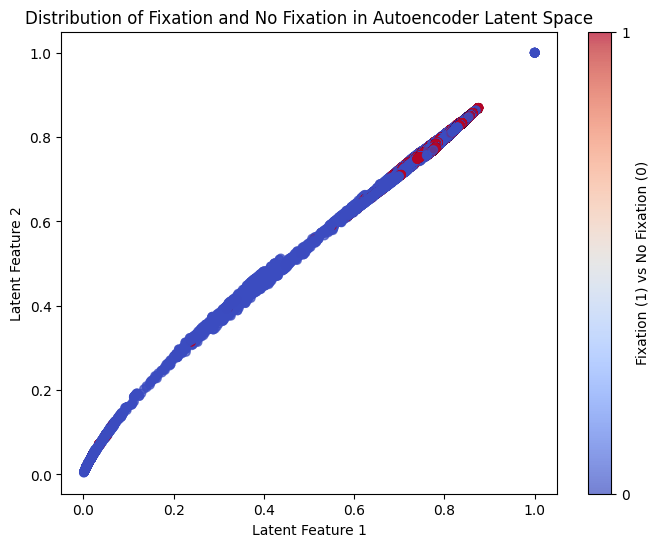

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the two latent features from the autoencoder bottleneck
latent_feature_1 = X_train_ae_overlap[:, 0]
latent_feature_2 = X_train_ae_overlap[:, 1]

# Ground truth labels for fixation (1) and no fixation (0)
fixation_labels = et_train_GT1_overlap.values.flatten()  # Ensure it's a 1D array

# Create the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_feature_1, latent_feature_2, c=fixation_labels, cmap='coolwarm', alpha=0.7)

# Add color bar
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.set_label('Fixation (1) vs No Fixation (0)')

# Labels and title
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('Distribution of Fixation and No Fixation in Autoencoder Latent Space')

# Show the plot
plt.show()


# VISUALIZING THE GAZE DATA

<ipython-input-170-7ae569e0946c>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
<ipython-input-170-7ae569e0946c>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


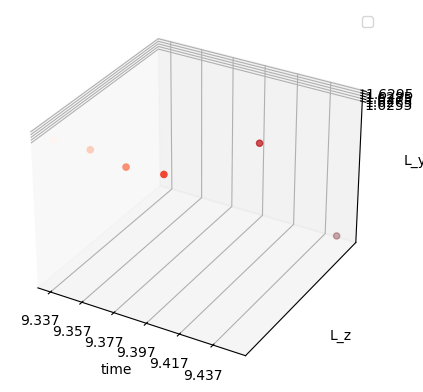

<Figure size 1500x1000 with 0 Axes>

In [170]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

ax = plt.figure().add_subplot(projection='3d')

# Make the grid
x, y, z = eye_tracking_data.loc[0:5,'time'], eye_tracking_data.loc[0:5,'L_z'], eye_tracking_data.loc[0:5,'L_y'],


# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('L_z')
ax.set_zlabel('L_y')


x_start = eye_tracking_data.loc[0, 'time'] #x.iloc[0]
x_end = eye_tracking_data.loc[20, 'time']
x_tick_values = np.arange(x_start, x_end, 0.02)
plt.xticks(x_tick_values)
# plt.xticks(np.arange(9.32, 9.38, 0.02))

y_start = eye_tracking_data.loc[0, 'L_z']
y_end = eye_tracking_data.loc[20, 'L_z']
y_tick_values = np.arange(y_start, y_end, 0.0001)
plt.yticks(y_tick_values)
# plt.yticks(np.arange(-1.24450, -1.24300, 0.0005))

z_start = eye_tracking_data.loc[0, 'L_y']
z_end = eye_tracking_data.loc[20, 'L_y']
z_tick_values = np.arange(z_start, z_end, 0.001)
ax.set_zticks(z_tick_values)
# ax.set_zticks(np.arange(1.6235, 1.6260, 0.001))


# Plot scatterplot data (20 2D points per colour) on the x and z axes.
# colors = ['r', 'g', "b", "k", "pink", "orange"] # this one limits the number of points to be displayed to the same number of colors

num_points = len(x)
cmap = cm.get_cmap('Reds')
norm = Normalize(vmin=0, vmax=num_points - 1)  # Normalize data
colors = [cmap(norm(i)) for i in range(num_points)]  # Generate color sequence

ax.scatter(x, y, z,  c=colors)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Gaze Points")


plt.show()